# PDS A2
You will be shared ten files from coders who annotated verses from the 1st book of Iliad (no names shared). In each file there are the following columns: polarity (the sentiment the reader felt while reading the verse), emotions, hero (Homer narrating or a hero talking). The goal of this assignment is to build Machine Learning for automated sentiment annotation.  

---

### 1. Exploring the data.
  * Address the missing values (and any outliers). 
  * Measure inter-annotator agreement in the *polarity* and *hero* columns.

---

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Import the filenames
import os
os.chdir(r'C:..\A2\IB1-annotated')
filename=os.listdir()
filenames=[]
for i in range(len(filename)):
    if 'xlsx' in filename[i]:
        filenames.append(filename[i])


#Create dataframe coders and add column ID
import pandas as pd
coders=pd.DataFrame([])
for i in range(len(filenames)):
    x=pd.read_excel(filenames[i])
    x['ID']=filenames[i][0:-5]   
    coders=pd.concat([coders,x])

    
#Combine column Unnamed with hero
for i in range(len(coders)):
    if pd.notna(coders['Unnamed: 4'].iloc[i]):
        coders['hero'].iloc[i]=coders['Unnamed: 4'].iloc[i]
                
coders=coders.drop(columns=['Unnamed: 4'])    
coders.isnull().sum(axis=0)


#Combine the similar written hero names as a unique name
names=coders['hero'].value_counts()
for i in range(len(coders)):
    if coders['hero'].iloc[i] in ['Kalhas','Kalchas']:
        coders['hero'].iloc[i]='Calchas'
    if coders['hero'].iloc[i] in ['Chrysis','CHRISIS','Hrisis']:
        coders['hero'].iloc[i]='Chryses'


#Calculate the mode of each column by verse        
modebyverse=coders.groupby('verse').agg(lambda x: pd.Series.mode(x))
modebyverse=modebyverse.drop(columns=['ID','emotions','hero'])
for i in range(len(modebyverse)):
    if len(modebyverse.polarity.iloc[i])<4:
        if (modebyverse.polarity.iloc[i][0]=='no emotion') and (modebyverse.polarity[i][1]=='positive'):
            modebyverse.polarity[i]=modebyverse.polarity[i][1]
        if modebyverse.polarity[i][0]=='negative' and modebyverse.polarity[i][1]=='positive':
            modebyverse.polarity[i]='no emotion'
        if modebyverse.polarity[i][0]=='negative' and modebyverse.polarity[i][1]=='no emotion':
            modebyverse.polarity[i]=modebyverse.polarity[i][0]  
        if len(modebyverse.polarity[i])==3:
            modebyverse.polarity[i]='no emotion'
            
modebyverseextra=coders.groupby('verse').agg(lambda x: pd.Series.mode(x)[0])
modebyverseextra=modebyverseextra.drop(columns=['ID','polarity'])        
modebyverse=pd.concat([modebyverse, modebyverseextra], axis=1)
modebyverse=modebyverse.rename(columns={'polarity':'modepolarity','emotions':'modeemotions','hero':'modehero'}) 
modebyverse.reset_index(level=0, inplace=True)


#Fill null values with the mode by verse
coders=pd.merge(coders,modebyverse, how='inner',on='verse')
for i in range(len(coders)):
    if pd.isnull(coders.hero[i]):
        coders.hero[i]=coders.modehero[i]
    if pd.isnull(coders.polarity[i]):
        coders.polarity[i]=coders.modepolarity[i]
    if pd.isnull(coders.emotions[i]):
        coders.emotions[i]=coders.modeemotions[i]

coders=coders.drop(columns=['modepolarity','modeemotions','modehero']) 
print(coders.isnull().sum())


#Drop verses that have only word
coders["words"]=coders["verse"].apply(lambda x: len(x))
coders=coders[coders.words>30]

verse       0
polarity    0
emotions    0
hero        0
ID          0
dtype: int64


After carefully reviewing the dataset. I filled the null values with the mode of each verse. Also, I dropped the verses that had only one word. I made sure that these verses did not correspond to a certain polarity, while annotators gave both negative and positive values incorrectly.

In [2]:
from sklearn.metrics import cohen_kappa_score as kappa

coders=coders.set_index([coders.index,'ID'])


#Calculate the Cohen's kappa values between each annotator
polarity=[]
hero=[]
for i in range(len(filenames)):
    for j in range(i+1,len(filenames)):
        polarity.append(kappa(coders.loc[pd.IndexSlice[:,filenames[i][0:-5]],['polarity']],coders.loc[pd.IndexSlice[:,filenames[j][0:-5]],['polarity']]))
        hero.append(kappa(coders.loc[pd.IndexSlice[:,filenames[i][0:-5]],['hero']],coders.loc[pd.IndexSlice[:,filenames[j][0:-5]],['hero']]))
        
#Calculate the mean of the kappa values
import numpy as np
print('The mean pairwise inter-annotator agreement for Polarity is '+"{:.2f}".format(np.mean(polarity)*100)+'%')
print('The mean pairwise inter-annotator agreement for Hero is '+"{:.2f}".format(np.mean(hero)*100)+'%')        

The mean pairwise inter-annotator agreement for Polarity is 17.14%
The mean pairwise inter-annotator agreement for Hero is 83.53%


Cohen's kappa calculates the percentage of inter-annotator aggreement taking into account the percentage agreement that would occur by chance. Hence, we observe that annotators had a relatively high agreement for the name of the heros at 83.53%, while the agreement for polarity is relatively small at 17.14%.

### 2. Data preprocessing.
  * Map the `polarity` (positive, negative, no emotion) to scores (respectively: 1, -1, 0). 
  * Perform a data exploratory analysis for `polarity` by visualising the class balance per annotator, and the variance per verse and per annotator. Combine `polarity` with `emotions` and `hero` to explore the data further (for example, one could study the aggregated sentiment-score per hero/narrator or the emotion distribution across the sentiment scores). Note that all figures should comply with the ten rules of visualisation that were taught in class. 
  * Suggest three findings (max: 50 words each) that will be based on the visualisations of your exploratory analysis.

---

In [3]:
# Map the polarity to scores (-1,0,1)
for i in range(len(coders)):
    if coders.polarity.iloc[i]=='positive':
        coders.polarity.iloc[i]=1
    else:
        if coders.polarity.iloc[i]=='negative':
            coders.polarity.iloc[i]=-1
        else:
            coders.polarity.iloc[i]=0

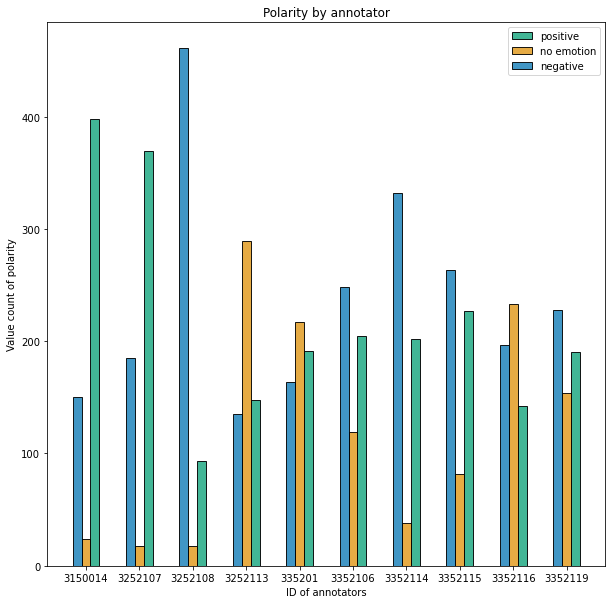

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=coders, x='ID', hue='polarity', stat='count', edgecolor='black',multiple="dodge",shrink=.5, palette='colorblind')
ax.set_title('Polarity by annotator')
ax.legend(labels=['positive', 'no emotion', 'negative'])
plt.xlabel('ID of annotators')
plt.ylabel('Value count of polarity')
plt.show()

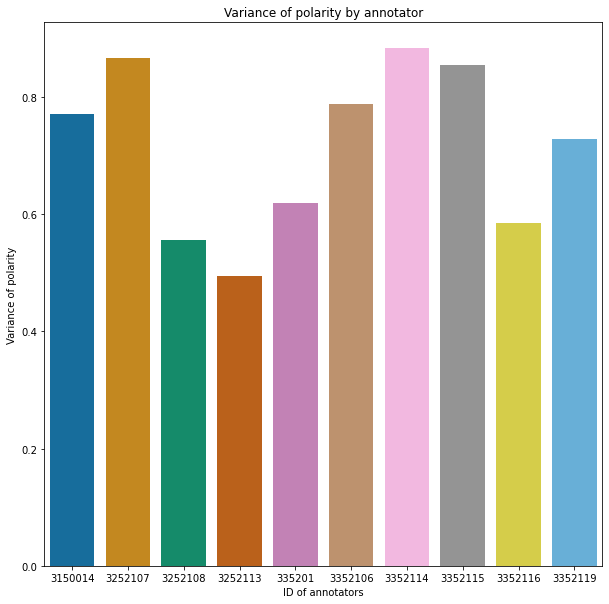

In [5]:
variance_annote=coders.groupby('ID')['polarity'].var()
variance_annote=variance_annote.reset_index()
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='ID',y='polarity',data=variance_annote,palette='colorblind')
ax.set_title('Variance of polarity by annotator')
plt.xlabel('ID of annotators')
plt.ylabel('Variance of polarity')
plt.show()

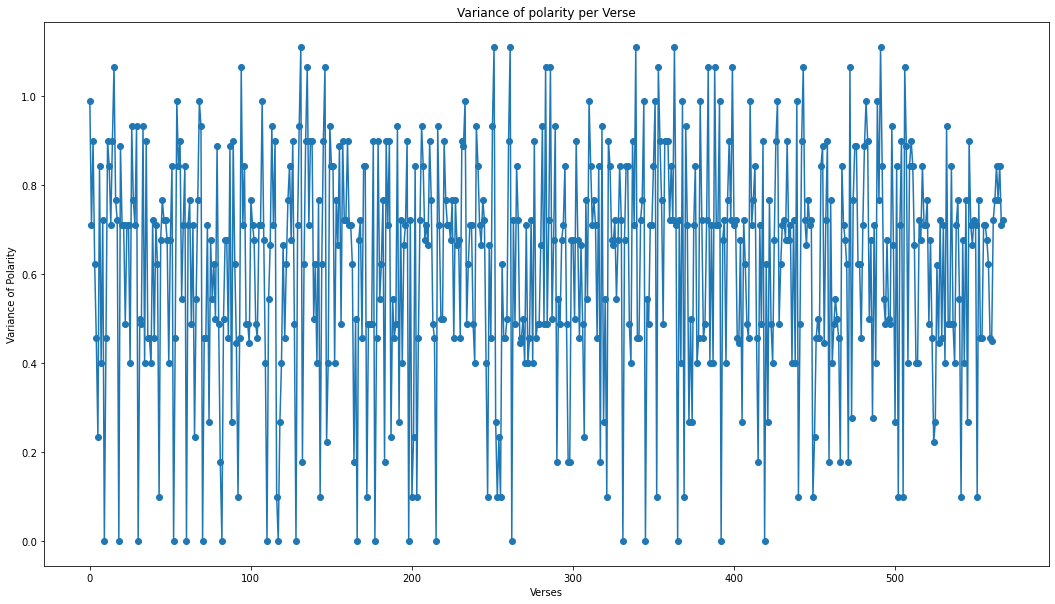

In [6]:
var_verse=coders.groupby('verse')['polarity'].var()
var_verse=var_verse.reset_index()
fig, ax = plt.subplots(figsize=(18, 10))
plt.plot(range(len(var_verse)), var_verse.polarity, 'o-')
ax.set_title('Variance of polarity per Verse')
plt.xlabel('Verses')
plt.ylabel('Variance of Polarity')
plt.show()

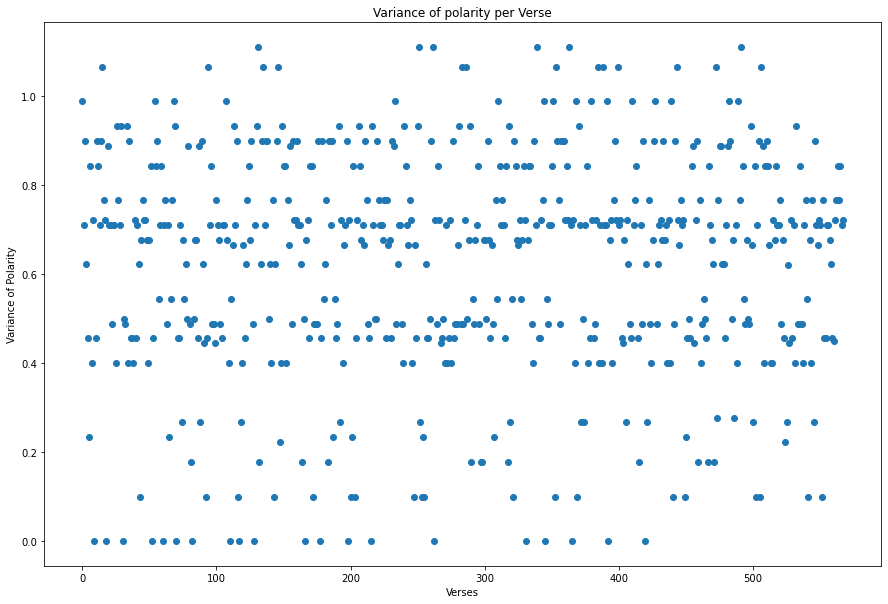

In [7]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(range(len(var_verse)), var_verse.polarity)
ax.set_title('Variance of polarity per Verse')
plt.xlabel('Verses')
plt.ylabel('Variance of Polarity')
plt.show()

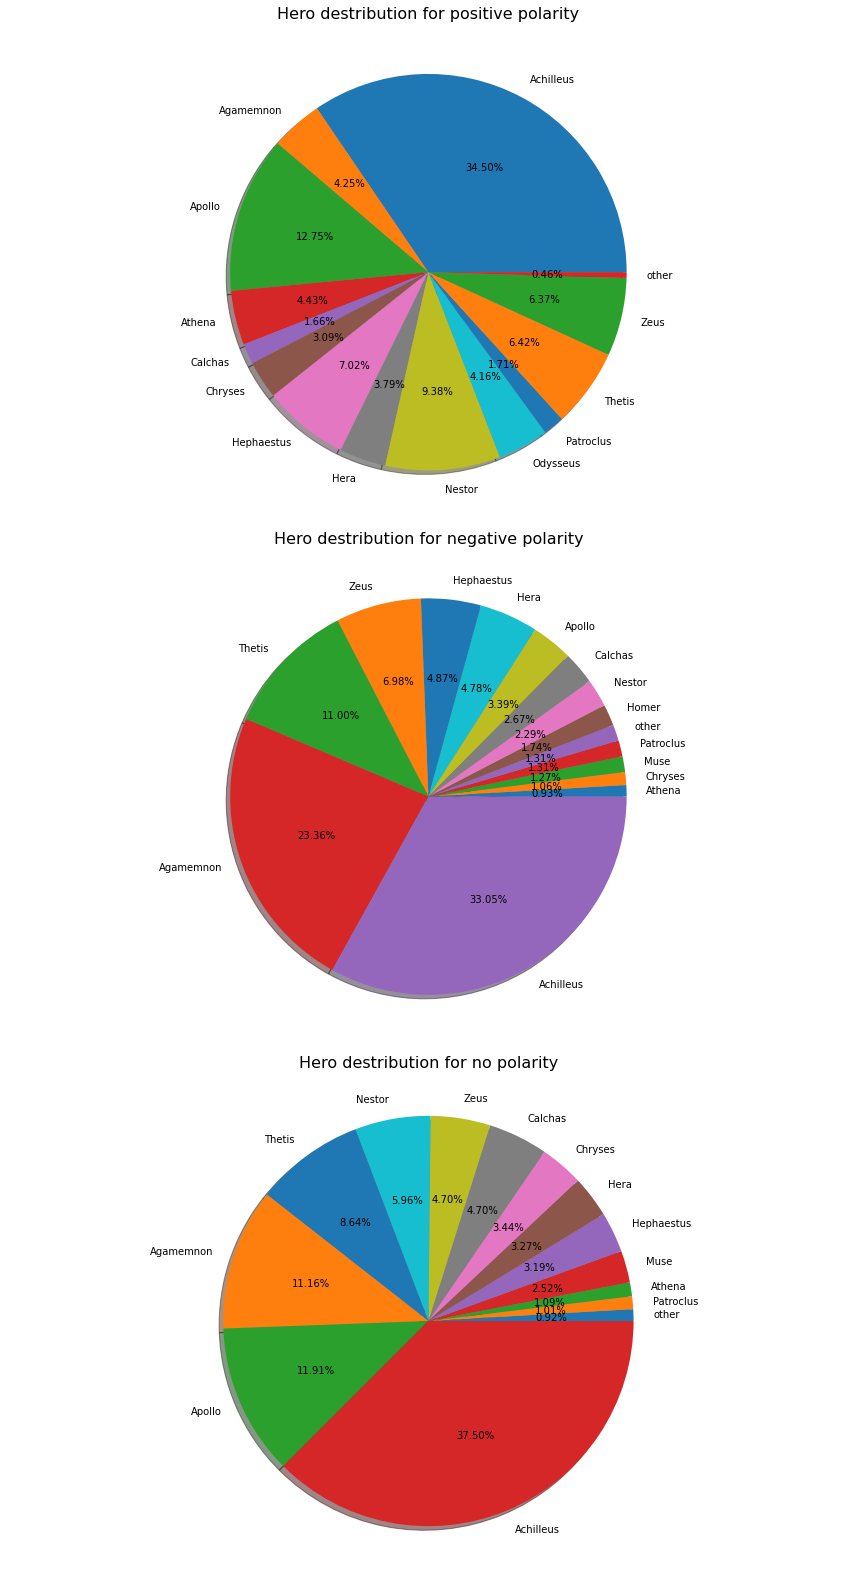

In [8]:
coders.polarity=coders.polarity.astype('int')

heros=coders[coders['polarity']>0]
heros=heros.hero.value_counts()
heros=heros.reset_index()
heros['name']=heros['index']

for i in range(len(heros)):
    if heros.hero.iloc[i]<36:
        heros.name.iloc[i]='other'
heros=heros.groupby('name')['hero'].sum()
heros=heros.reset_index()
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12, 22))
ax1.set_title('Hero destribution for positive polarity',fontsize=16)
ax1.pie(heros.hero,labels=heros.name, shadow=True, autopct='%1.2f%%')
plt.axis('equal')
plt.tight_layout()


heros=coders[coders['polarity']<0]
heros=heros.hero.value_counts()
heros=heros.reset_index()
heros['name']=heros['index']
for i in range(len(heros)):
    if heros.hero.iloc[i]<22:
        heros.name.iloc[i]='other'
heros=heros.groupby('name')['hero'].sum()
heros=heros.sort_values()
heros=heros.reset_index()
ax2.set_title('Hero destribution for negative polarity',fontsize=16)
ax2.pie(heros.hero,labels=heros.name, shadow=True, autopct='%1.2f%%')
plt.tight_layout()


heros=coders[coders['polarity']==0]
heros=heros.hero.value_counts()
heros=heros.reset_index()
heros['name']=heros['index']
for i in range(len(heros)):
    if heros.hero.iloc[i]<12:
        heros.name.iloc[i]='other'
heros=heros.groupby('name')['hero'].sum()
heros=heros.sort_values()
heros=heros.reset_index()
ax3.set_title('Hero destribution for no polarity',fontsize=16)
ax3.pie(heros.hero,labels=heros.name, shadow=True, autopct='%1.2f%%')
plt.tight_layout()
plt.show()

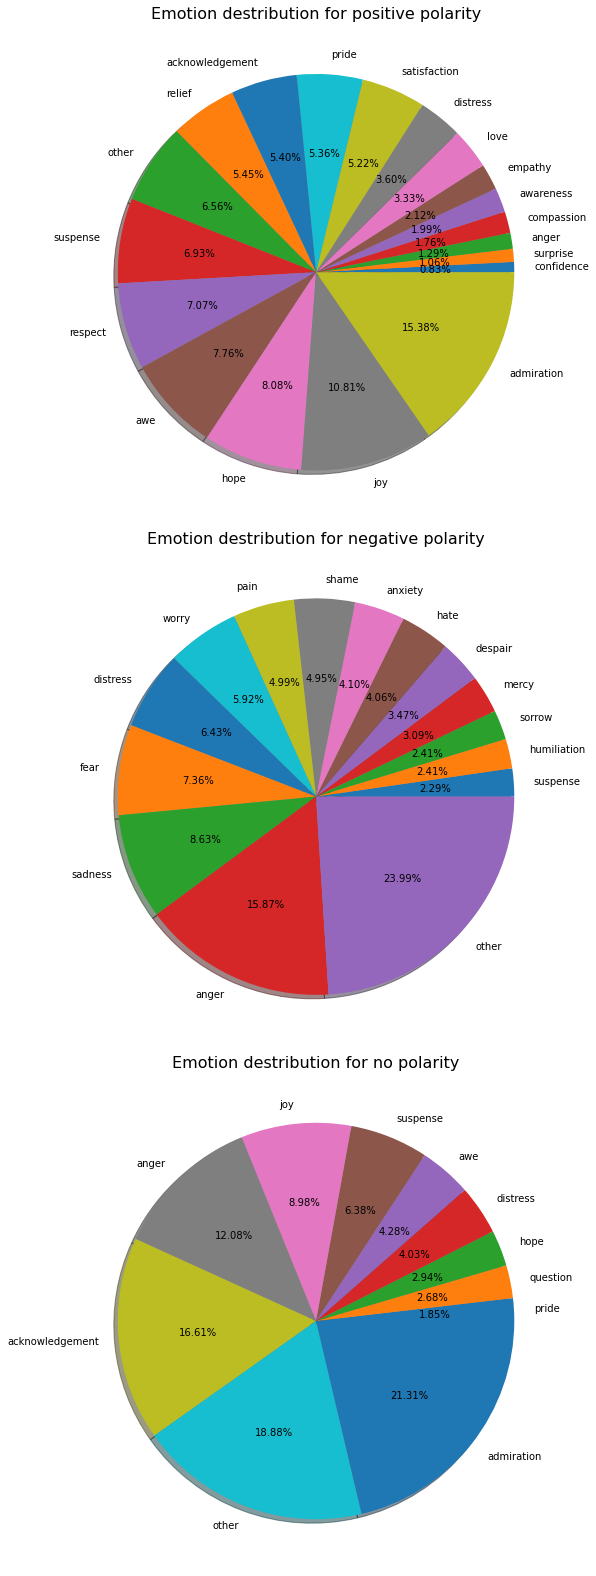

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,22))
emotions=coders[coders['polarity']>0]
emotions=emotions.emotions.value_counts()
emotions=emotions.reset_index()
emotions['name']=emotions['index']
for i in range(len(emotions)):
    if emotions.emotions.iloc[i]<18:
        emotions.name.iloc[i]='other'
emotions=emotions.groupby('name')['emotions'].sum()
emotions=emotions.sort_values()
emotions=emotions.reset_index()
ax1.set_title('Emotion destribution for positive polarity',fontsize=16)
ax1.pie(emotions.emotions,labels=emotions.name, shadow=True, autopct='%1.2f%%')
plt.tight_layout()


emotions=coders[coders['polarity']<0]
emotions=emotions.emotions.value_counts()
emotions=emotions.reset_index()
emotions['name']=emotions['index']
for i in range(len(emotions)):
    if emotions.emotions.iloc[i]<54:
        emotions.name.iloc[i]='other'
emotions=emotions.groupby('name')['emotions'].sum()
emotions=emotions.sort_values()
emotions=emotions.reset_index()
ax2.set_title('Emotion destribution for negative polarity',fontsize=16)
ax2.pie(emotions.emotions,labels=emotions.name, shadow=True, autopct='%1.2f%%')
plt.tight_layout()


emotions=coders[coders['polarity']==0]
emotions=emotions.emotions.value_counts()
emotions=emotions.reset_index()
emotions['name']=emotions['index']
for i in range(len(emotions)):
    if emotions.emotions.iloc[i]<22:
        emotions.name.iloc[i]='other'
emotions=emotions.groupby('name')['emotions'].sum()
emotions=emotions.sort_values()
emotions=emotions.reset_index()
ax3.set_title('Emotion destribution for no polarity',fontsize=16)
ax3.pie(emotions.emotions,labels=emotions.name, shadow=True, autopct='%1.2f%%')
plt.tight_layout()

plt.show()

Findings based on the visualisations of the exploratory analysis:
1. Based on the nature of Iliad we expect annotators to fill the polarity mostly negatively. However, it is observed through the first graph that each annotator filled the polarity with different criterion. The annotations do not match, as some filled mostly with positive and others mostly with negative values.

2. it is observed from the third and forth graph that there is high variance in most of the verses. This points in differences between the annotations of the annotators in each verse.

3. It is observed through the last graph with the pie charts, that some annotators filled positive polarity with emotions like anger and distress and some filled no emotion polarity with emotions like joy and anger. These findings point that the annotations by some annotators may not be carefullly considered and that this inconsistency may affect our work.


### 3. Automated annotation.
 * Build baselines (at least one based on random guesses) and regressors (at least three sklearn-based) that will yield a score (from -1 to 1) estimating the reader's sentiment for an unseen verse. 
 * Evaluate your models using mean absolute error (MAE) and mean square error (MSE). Turn the gold and predicted scores to classes (-1, 0, 1) and evaluate also using *proper* classification evaluation metrics.  
 * Diagnose and analyse any under/over fitting. 
 * Announce a winner based on your evaluation and apply it in order to predict a label (not score) per verse on the 24th Iliad book that is given. Submit your predictions as a compressed CSV with the following title: `IB24.your-student-ID-number.csv.gz`, where `your-student-ID-number` will hold your student ID number). The submitted dataframe should comprise the verses in one column (exactly as the original), but it should also comprise another column to hold the aligned predictions. 

 ---

In [10]:
#Create a dataframe that includes the ground truth for each verse
truth=coders.groupby('verse')['polarity'].mean()
truth=truth.reset_index()
truth=truth.rename(columns={'polarity':'groundtruth'})

#Merge the groundtruth of each verse in the whole dataset
coders=pd.merge(coders,truth, how='inner',on='verse')

The groundtruth was created by taking the mean average of the polarity values for each verse.

In [21]:
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

#Build a baseline base on random guesses
baseline=[random.uniform(-1,1) for i in range(len(truth))]

print(mse(truth.groundtruth,baseline))
print(mae(truth.groundtruth,baseline))

0.5990931917223228
0.6231866395271365


The mean squeared error for the baseline model is 0.6. Hence, the model that will be created needs to have an MSE lower than that of the baseline's.

In [22]:
#Create a train and a test dataset to create and evaluate the model
train=coders[coders.index<(len(coders)-1100)]
test=coders[coders.index>=(len(coders)-1100)]

#Use the TfidVectorizer we were taught in lecture to split the verses in words, so we can create our model
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train.verse)
y = train.polarity

#Get the names of the verses
fnames = vectorizer.get_feature_names()

#Create a list with stopwords
stopwords=[]
for i in range(len(fnames)):
    if len(fnames[i])<3:
        stopwords.append(fnames[i])
        
#Apply the stopwords
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(train.verse)
y = train.polarity

I decided to use the whole dataset (instead of the groundtruth dataset), to create the model and use each one of the polarity values that annotators gave. This approach includes same verses but with different polarities, so the model will be trained based on that. The train and the test datasets were split in a way, which test data set includes only verses that are not included in the train set. Also, stop words were used in TfidVectozer that are constisted of words with less than 3 strings. Hence, stop words include 32 words. Words with more letters were also tested, but some words were crusial to polarity value. I could use libraries with greek words or search for specific not significant words, but there were time limits. 

In [23]:
#Import libraries with sklearn-based regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report

In [24]:
#Linear model

#Fit the model
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
predictions = lr.predict(vectorizer.transform(test.verse))

#Calculate MSE and MAE
print('For the test set MSE=',mse(test.groundtruth,predictions))
print('For the train set MSE=', mse(train.groundtruth,lr.predict(vectorizer.transform(train.verse))) )
print('For the test set MAE=',mae(test.groundtruth,predictions))


#Predict the class based on thresholds
test["predictions"]= predictions
test['predictionsclass']=0
test['truthclass']=0
for i in range(len(test)):
    if test.groundtruth.iloc[i]>0.1:
        test['truthclass'].iloc[i]=1
    else:
        if test.groundtruth.iloc[i]<-0.1:
            test['truthclass'].iloc[i]=-1
            
for i in range(len(test)):
    if test.predictions.iloc[i]>0.1:
        test['predictionsclass'].iloc[i]=1
    else:
        if test.predictions.iloc[i]<-0.1:
            test['predictionsclass'].iloc[i]=-1

            
#Calculate the necessary metrics to evaluate the classification
print(test.predictionsclass.value_counts())
print(test.truthclass.value_counts())
print(classification_report(test.truthclass,test.predictionsclass))

For the test set MSE= 0.26258723246589966
For the train set MSE= 0.00018398268398971427
For the test set MAE= 0.39275076727551683
-1    480
 0    310
 1    310
Name: predictionsclass, dtype: int64
-1    480
 1    420
 0    200
Name: truthclass, dtype: int64
              precision    recall  f1-score   support

          -1       0.52      0.52      0.52       480
           0       0.23      0.35      0.27       200
           1       0.48      0.36      0.41       420

    accuracy                           0.43      1100
   macro avg       0.41      0.41      0.40      1100
weighted avg       0.45      0.43      0.43      1100



In [25]:
#Linear Ridge model

#Fit the model
lr = Ridge(alpha=1,fit_intercept=False)
lr.fit(X, y)
predictions = lr.predict(vectorizer.transform(test.verse))

#Calculate MSE and MAE
print('For the test set MSE=',mse(test.groundtruth,predictions))
print('For the train set MSE=', mse(train.groundtruth,lr.predict(vectorizer.transform(train.verse))) )
print('For the test set MAE=',mae(test.groundtruth,predictions))


#Predict the class based on thresholds
test["predictions"]= predictions
test['predictionsclass']=0
test['truthclass']=0
for i in range(len(test)):
    if test.groundtruth.iloc[i]>0.1:
        test['truthclass'].iloc[i]=1
    else:
        if test.groundtruth.iloc[i]<-0.1:
            test['truthclass'].iloc[i]=-1
            
for i in range(len(test)):
    if test.predictions.iloc[i]>0.1:
        test['predictionsclass'].iloc[i]=1
    else:
        if test.predictions.iloc[i]<-0.1:
            test['predictionsclass'].iloc[i]=-1

            
#Calculate the necessary metrics to evaluate the classification
print(test.predictionsclass.value_counts())
print(test.truthclass.value_counts())
print(classification_report(test.truthclass,test.predictionsclass))

For the test set MSE= 0.23617139992551983
For the train set MSE= 0.004151301153090745
For the test set MAE= 0.37500434737370153
-1    470
 0    320
 1    310
Name: predictionsclass, dtype: int64
-1    480
 1    420
 0    200
Name: truthclass, dtype: int64
              precision    recall  f1-score   support

          -1       0.53      0.52      0.53       480
           0       0.25      0.40      0.31       200
           1       0.45      0.33      0.38       420

    accuracy                           0.43      1100
   macro avg       0.41      0.42      0.41      1100
weighted avg       0.45      0.43      0.43      1100



In [26]:
#KNeighborsRegressor model

#Fit the model
lr = KNeighborsRegressor(n_neighbors=6)
lr.fit(X, y)
predictions = lr.predict(vectorizer.transform(test.verse))

#Calculate MSE and MAE
print('For the test set MSE=',mse(test.groundtruth,predictions))
print('For the train set MSE=', mse(train.groundtruth,lr.predict(vectorizer.transform(train.verse))) )
print('For the test set MAE=',mae(test.groundtruth,predictions))


#Predict the class based on thresholds
test["predictions"]= predictions
test['predictionsclass']=0
test['truthclass']=0
for i in range(len(test)):
    if test.groundtruth.iloc[i]>0.1:
        test['truthclass'].iloc[i]=1
    else:
        if test.groundtruth.iloc[i]<-0.1:
            test['truthclass'].iloc[i]=-1
            
for i in range(len(test)):
    if test.predictions.iloc[i]>0.1:
        test['predictionsclass'].iloc[i]=1
    else:
        if test.predictions.iloc[i]<-0.1:
            test['predictionsclass'].iloc[i]=-1

            
#Calculate the necessary metrics to evaluate the classification
print(test.predictionsclass.value_counts())
print(test.truthclass.value_counts())
print(classification_report(test.truthclass,test.predictionsclass))

For the test set MSE= 0.3820151515151515
For the train set MSE= 0.03360990860990862
For the test set MAE= 0.48484848484848486
-1    520
 1    500
 0     80
Name: predictionsclass, dtype: int64
-1    480
 1    420
 0    200
Name: truthclass, dtype: int64
              precision    recall  f1-score   support

          -1       0.56      0.60      0.58       480
           0       0.25      0.10      0.14       200
           1       0.56      0.67      0.61       420

    accuracy                           0.54      1100
   macro avg       0.46      0.46      0.44      1100
weighted avg       0.50      0.54      0.51      1100



In [27]:
#RandomForestRegressor model

#Fit the model
lr = RandomForestRegressor()
lr.fit(X, y)
predictions = lr.predict(vectorizer.transform(test.verse))

#Calculate MSE and MAE
print('For the test set MSE=',mse(test.groundtruth,predictions))
print('For the train set MSE=', mse(train.groundtruth,lr.predict(vectorizer.transform(train.verse))) )
print('For the test set MAE=',mae(test.groundtruth,predictions))


#Predict the class based on thresholds
test["predictions"]= predictions
test['predictionsclass']=0
test['truthclass']=0
for i in range(len(test)):
    if test.groundtruth.iloc[i]>0.1:
        test['truthclass'].iloc[i]=1
    else:
        if test.groundtruth.iloc[i]<-0.1:
            test['truthclass'].iloc[i]=-1
            
for i in range(len(test)):
    if test.predictions.iloc[i]>0.1:
        test['predictionsclass'].iloc[i]=1
    else:
        if test.predictions.iloc[i]<-0.1:
            test['predictionsclass'].iloc[i]=-1

            
#Calculate the necessary metrics to evaluate the classification
print(test.predictionsclass.value_counts())
print(test.truthclass.value_counts())
print(classification_report(test.truthclass,test.predictionsclass))

For the test set MSE= 0.222201572747794
For the train set MSE= 0.000674256796925389
For the test set MAE= 0.38013183872462275
-1    630
 0    320
 1    150
Name: predictionsclass, dtype: int64
-1    480
 1    420
 0    200
Name: truthclass, dtype: int64
              precision    recall  f1-score   support

          -1       0.46      0.60      0.52       480
           0       0.22      0.35      0.27       200
           1       0.47      0.17      0.25       420

    accuracy                           0.39      1100
   macro avg       0.38      0.37      0.35      1100
weighted avg       0.42      0.39      0.37      1100



In [28]:
#Lasso model

#Fit the model
lr = Lasso(alpha=0.0001,fit_intercept=False,max_iter=10000)
lr.fit(X, y)
predictions = lr.predict(vectorizer.transform(test.verse))

#Calculate MSE and MAE
print('For the test set MSE=',mse(test.groundtruth,predictions))
print('For the train set MSE=', mse(train.groundtruth,lr.predict(vectorizer.transform(train.verse))) )
print('For the test set MAE=',mae(test.groundtruth,predictions))


#Predict the class based on thresholds
test["predictions"]= predictions
test['predictionsclass']=0
test['truthclass']=0
for i in range(len(test)):
    if test.groundtruth.iloc[i]>0.1:
        test['truthclass'].iloc[i]=1
    else:
        if test.groundtruth.iloc[i]<-0.1:
            test['truthclass'].iloc[i]=-1
            
for i in range(len(test)):
    if test.predictions.iloc[i]>0.1:
        test['predictionsclass'].iloc[i]=1
    else:
        if test.predictions.iloc[i]<-0.1:
            test['predictionsclass'].iloc[i]=-1

            
#Calculate the necessary metrics to evaluate the classification
print(test.predictionsclass.value_counts())
print(test.truthclass.value_counts())
print(classification_report(test.truthclass,test.predictionsclass))

For the test set MSE= 0.3959992508325421
For the train set MSE= 0.006941870597202099
For the test set MAE= 0.47377777585484926
-1    490
 1    360
 0    250
Name: predictionsclass, dtype: int64
-1    480
 1    420
 0    200
Name: truthclass, dtype: int64
              precision    recall  f1-score   support

          -1       0.45      0.46      0.45       480
           0       0.40      0.50      0.44       200
           1       0.53      0.45      0.49       420

    accuracy                           0.46      1100
   macro avg       0.46      0.47      0.46      1100
weighted avg       0.47      0.46      0.46      1100



The baseline model that was created based on random guesses from -1 to 1 has a value of Mean square error (MSE) of 0.6. Based on that, our models need to have a lower MSE to be accepted. A lower MSE indicates a better model. However, if the MSE of train data set we used for the training of our model is too small, there may be an indication of overfitting. No model shows signs of underfitting (high MSE). In addition, all the models have a lower MSE than the baseline model, so all the models fulfil the necessary criterion.

The thresholds values that classify the scores of the models into polarity were carefully selected at (0.1,1) as positive polarity, (-0.1,0.1) as no emotion and (-1,-0.1) as negative polarity. These values create the same percentages of (-1,0,-1) using the ground truth values, as the percentages of (-1,0,1) that the annotators used. These scores seem to be the most accurate, as the thresholds of (-0.33,0.33) seem to turn the majority of the classes into 'no emotion', which increases the accuracy of the model, although the model is qualitatively worse. 

Linear Model: 
The higher MSE of the test set in comparison to the other models. Also, a really small MSE for the train data set which indicates overfitting. Based on that, the model is rejected.

Ridge Model:
The lower MSE of the test set in comparison to the other models, but the second smallest MSE for the train data set which indicates overfitting. Based on that, the model is rejected.

KNeighbors model:
The best model out of the five. Lower MSE for the test set than the baseline. Acceptable MSE for the train set. The best scores in accuracy (0.54), weighted f1 score(0.51) and precision (0.5). 

Random forest model:
Low MSE for the test set and the train set. Acceptable acccuracy score,precision score and f1 score compared to other models.

Lasso model:
A very low MSE of the test set in comparison to the other models, but the smallest MSE for the train data set which indicates overfitting. Based on that, the model is rejected.

Based on the above the KNeighbors Regressor model is selected. It has small MSE and the best scores for classification evaluation metrics. This model predicts accurately the most values of the ground truth.

In [29]:
#Apply the Tfidvectorizer in the whole data set
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(coders.verse)
y = coders.polarity

#Get the names of the verses
fnames = vectorizer.get_feature_names()

#Create a list with stopwords
stopwords=[]
for i in range(len(fnames)):
    if len(fnames[i])<3:
        stopwords.append(fnames[i])
        
#Apply the stopwords
vectorizer = TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(coders.verse)
y = coders.polarity

In [30]:
#KNeighborsRegressor model

#Fit the model
lr = KNeighborsRegressor(n_neighbors=6)
lr.fit(X, y)


#Import the 24th Iliad book
os.chdir(r'C:..\A2')
I24=pd.read_excel('I24.xlsx')


#Predict the score of the verses of 24th Iiad book
predictions = lr.predict(vectorizer.transform(I24.verse))


#Predict the class based on thresholds
I24["predictions"]= predictions
I24['predictionsclass']=0           
for i in range(len(I24)):
    if I24.predictions.iloc[i]>0.1:
        I24['predictionsclass'].iloc[i]=1
    else:
        if I24.predictions.iloc[i]<-0.1:
            I24['predictionsclass'].iloc[i]=-1

            
print(I24.predictionsclass.value_counts())

-1    408
 1    346
 0     76
Name: predictionsclass, dtype: int64



### 4. Scraping and silver labeling.
 * Scrape all the books of Iliad, by using this [translation from Project Gutenberg](https://www.gutenberg.org/cache/epub/36248/pg36248-images.html).
 * Use your best performing sentiment classifier from (3) to label the verses of all the 24 crawled books (silver labeling).  
 * Visualise the sentiment series resulted from the silver labels of all the books. 
 * Evaluate your model's predictions for the 1st scraped book with the respective gold annotations (of the same book from T3, yet with a different translation), which you used to train your model.

In [31]:
import requests
from bs4 import BeautifulSoup
r = requests.get("https://www.gutenberg.org/cache/epub/36248/pg36248-images.html")
html = r.content
soup = BeautifulSoup(html, 'html.parser')

verses=[]
#All the verses start and end with 'td'
text=soup.find_all('td')
for verse in text:
    verses.append(verse.get_text())
    
books=[]
for i in range(len(verses)):
    if len(verses[i])>3:
        books.append(verses[i])
   
books=pd.DataFrame(books)    
books=books.rename(columns={0:'verses'})

In [32]:
#Predict the score of the verses of all the Iiad
predictions = lr.predict(vectorizer.transform(books.verses))


#Predict the class based on thresholds
books["predictions"]= predictions
books['predictionsclass']=0           
for i in range(len(books)):
    if books.predictions.iloc[i]>0.1:
        books['predictionsclass'].iloc[i]=1
    else:
        if books.predictions.iloc[i]<-0.1:
            books['predictionsclass'].iloc[i]=-1

            
print(books.predictionsclass.value_counts())

-1    6075
 1    5279
 0    1351
Name: predictionsclass, dtype: int64


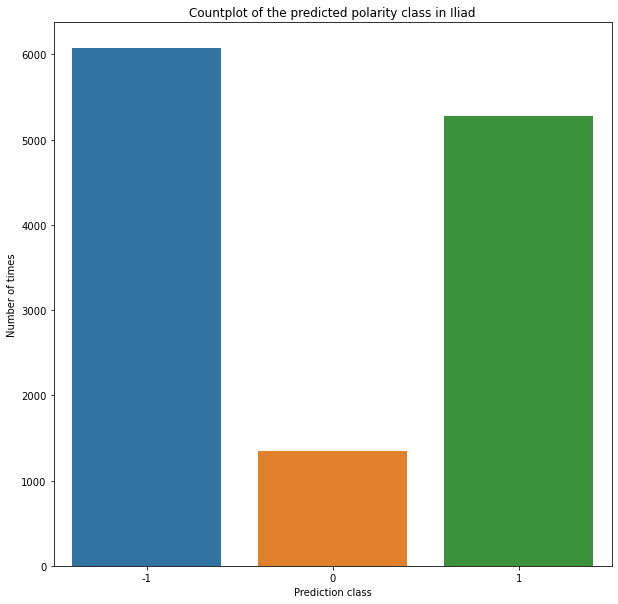

In [33]:
#Visualise the number of (-1,0,1) resulted in the Iliad
fig, ax = plt.subplots(figsize=(10, 10))
sns.countplot(data=books, x=books.predictionsclass)
ax.set_title('Countplot of the predicted polarity class in Iliad')
plt.xlabel('Prediction class')
plt.ylabel('Number of times')
plt.show()

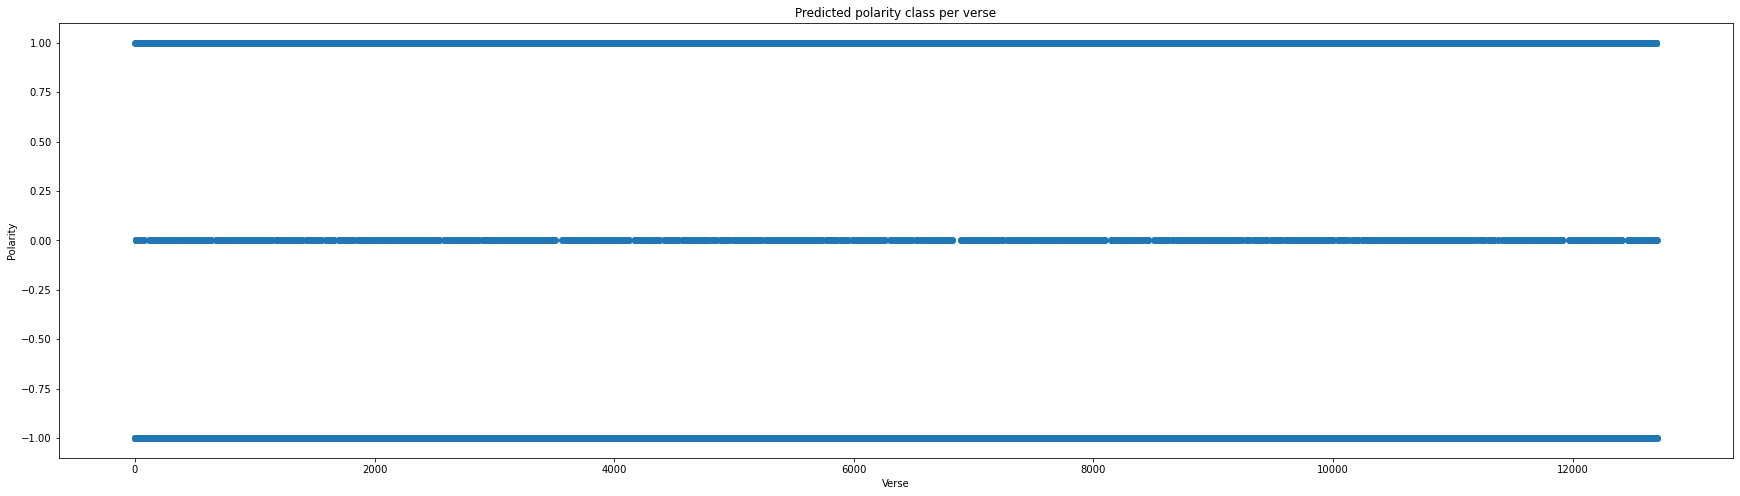

In [34]:
fig, ax = plt.subplots(figsize=(30, 8))
plt.scatter(range(len(books)),books.predictionsclass)
ax.set_title('Predicted polarity class per verse')
plt.xlabel('Verse')
plt.ylabel('Polarity')
plt.show()

The above graph shows that the values of polarity class are spread between the verses and that there are not books with only negative or only positive values.

In [35]:
#Create the gold labels of the groundtruth values
truth['gold']=0           
for i in range(len(truth)):
    if truth.groundtruth.iloc[i]>0.1:
        truth['gold'].iloc[i]=1
    else:
        if truth.groundtruth.iloc[i]<-0.1:
            truth['gold'].iloc[i]=-1 

print(truth.gold.value_counts())         

-1    252
 1    216
 0    100
Name: gold, dtype: int64


In [36]:
#Take the first scraped book with the different translation from Iliad
print(books[books['verses']=="κοιμούνταν, κι' η χρυσόθρονη θεά κοντά του, η Ήρα."].index.values)      
firstbook=books[books.index<=649]

[649]


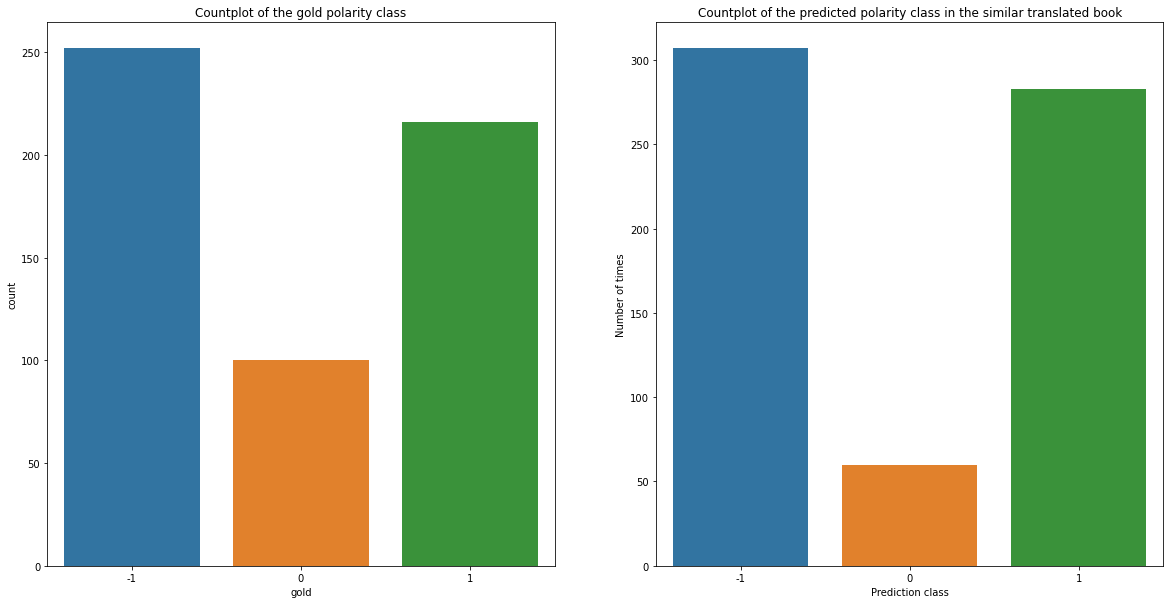

In [37]:
#Visualise the number of (-1,0,1) resulted in the first book of Iliad from the gold and silver labels
fig, ax = plt.subplots(1,2,figsize=(20, 10))

sns.countplot(data=truth, x=truth.gold, ax=ax[0])
ax[0].set_title('Countplot of the gold polarity class')
plt.xlabel('Gold Class')
plt.ylabel('Number of times')

sns.countplot(data=firstbook, x=firstbook.predictionsclass, ax=ax[1])
ax[1].set_title('Countplot of the predicted polarity class in the similar translated book')
plt.xlabel('Prediction class')
plt.ylabel('Number of times')

plt.show()

The above graphs depict the number of (-1,0,1) from the same verses with different translations from T3 and T4 respectively. It can be observed that in both graphs -1 is the most common value, followed by 1. The only difference seems to be in the number of zeros, as the model seems to classify less zeros. However, the predicted values seem to be similar to the gold values.

In [ ]:
#Found in 'https://stackoverflow.com/questions/37193157/apply-gzip-compression-to-a-csv-in-python-pandas/46073397'
I24.to_csv('IB24.f3352112.csv.gz', compression='gzip')
truth.to_csv('IB1.f3352112.csv.gz', compression='gzip')
books.to_csv('iliad_from_gutenberg.f3352112.csv.gz', compression='gzip')


### Evaluation criteria: 
  * The four tasks are equally weighted in terms of grades (25% each). 
  * With this assignment you are expected to do data preprocessing, exploratory analysis, train and evaluate machine learning models, employ (scraping and) visualisation as an analysis tool. 
  * The code cells that solve a task should follow the cell with the respective task description. Any textual analysis/description should exist in **text** cells (not in the source code) following the code cells that solve the related task. Use Jupyter's markdown-cell option to add text cells. 
  * If you borrow a solution that exists online, name the link you took it from and what you did to adapt it to your task. Detected plagiarism (esp. copying from a source without quoting and duplicate code between students) will lead to a zero grade.
  * Your code should be well-structured and comments should explain as much as possible, to avoid misunderstandings during evaluation (points might be lost due to this).
  * Everyone will be assessed by their written notebook, but if there are questions, some may be asked to explain in brief orally.

---